# Prototyping

### Libraries

In [118]:
## Basic
import operator
import numpy as np
from sklearn.decomposition import PCA
import scipy.stats
import scipy

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# VAE (most simple)

## Load Data

In [128]:
from keras.datasets import mnist

# MNIST ______________________________________________________________

(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

[5 0 4 ... 5 6 8]


## Build Model

In [14]:
'''Example of VAE on MNIST dataset using MLP
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean = 0 and std = 1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-Encoding Variational Bayes."
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


## MODEL ______________________________________________________________

# network parameters
modelArgs = {"input_shape": (original_dim, ), "intermediate_dim": 512, "latent_dim": 14}


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=modelArgs["input_shape"], name='encoder_input')
x = Dense(modelArgs["intermediate_dim"], activation='relu')(inputs)
z_mean = Dense(modelArgs["latent_dim"], name='z_mean')(x)
z_log_var = Dense(modelArgs["latent_dim"], name='z_log_var')(x)




## Reparameterization Trick__________________________________________

# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(modelArgs["latent_dim"],), name='z')([z_mean, z_log_var])




## INSTANTIATE ________________________________________________

## 1) instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

## 2) build decoder model
latent_inputs = Input(shape=(modelArgs["latent_dim"],), name='z_sampling')
x = Dense(modelArgs["intermediate_dim"], activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

## 3) instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

## 4) instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 14)           7182        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 14)           7182        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

## Train Model

In [15]:
## Configs  

trainArgs = {"loss": "mse", "weights": "load", "batch_size": 128, "epochs": 50, "beta": 1.0}

models = (encoder, decoder)
data = (x_test, y_test)

# VAE loss = mse_loss or xent_loss + kl_loss

if trainArgs["loss"] == "mse":
    reconstruction_loss = mse(inputs, outputs)
if trainArgs["loss"] == "binary_crossentropy":
    reconstruction_loss = binary_crossentropy(inputs, outputs)


## LOSS _____________________________________________

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + (trainArgs["beta"] * kl_loss))
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
#plot_model(vae,to_file='vae_mlp.png',show_shapes=True)


## TRAIN______________________________________________

# load the autoencoder weights

if trainArgs["weights"] == "load":
    
    vae.load_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")

# train the autoencoder

elif trainArgs["weights"] == "train":
    vae.fit(x_train, epochs=trainArgs["epochs"], batch_size=trainArgs["batch_size"], validation_data=(x_test, None))
    vae.save_weights("models/weights/vae_mlp_mnist_latent_dim_" + str(modelArgs["latent_dim"]) + ".h5")



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 14), (None, 14),  416284    
_________________________________________________________________
decoder (Model)              (None, 784)               409872    
Total params: 826,156
Trainable params: 826,156
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 78us/step - loss: 45.5486 - val_loss: 35.6392
Epoch 2/50
60000/60000 [==============================] - 4s 67us/step - loss: 34.5935 - val_loss: 33.2661
Epoch 3/50
60000/60000 [==============================] - 6s 99us/step - loss: 33.0425 - val_loss: 32.2826
Epoch 4/50
60000/60000 [=====

## Analyze Latent Space

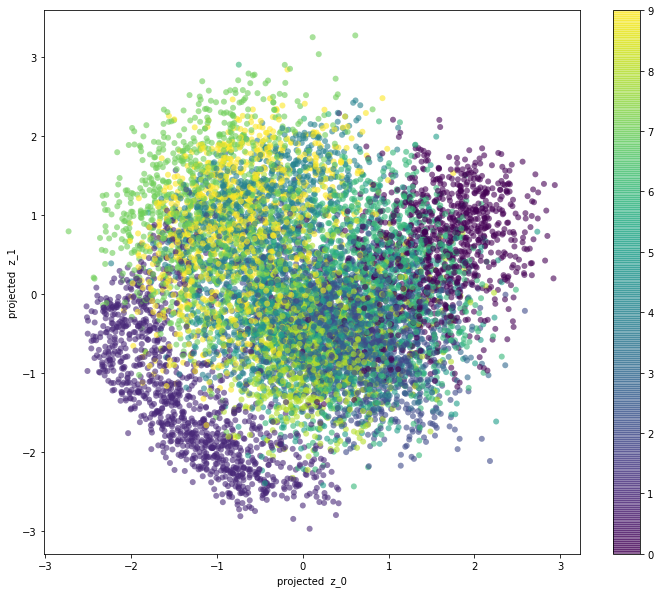

In [16]:
analyzeArgs = {"save_plots": False}


def analyze_latent_space(models,data,batch_size=128,model_name="vae_mnist"):
    
    """Plots labels and data as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models  # trained models
    x_test, y_test = data

    
    ## ENCODER - 2D Digit Classes _________________________________________
    
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size = batch_size)
    
    
    ## DIMENSIONALITY REDUCTION _______________________
    
    pca = PCA(n_components=2)
    projected_z = pca.fit_transform(z_mean) 
    
    ## toDO: add t-SNE
    
    
    # Plot_____________________________
    
    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.show()
    
    plt.figure(figsize=(12, 10))
    plt.scatter(projected_z[:, 0], projected_z[:, 1], c=y_test, edgecolor='none', alpha=0.6)
    plt.xlabel('projected  z_0')
    plt.ylabel('projected  z_1')
    plt.colorbar()
    
    
    if analyzeArgs["save_plots"] == True:
            os.makedirs(model_name, exist_ok=True)
            filename = os.path.join(model_name, "vae_mean.png")
            plt.savefig(filename)
            
            
            
    ## ENCODER - Distribution _________________________________________
    
    ## toDO: add latent space plots
    
        
    # display a 2D plot of the digit classes in the latent space
    #z_mean, _, _ = encoder.predict(x_test, batch_size = batch_size)
    
    # Plot_____________________________

    #plt.figure(figsize=(12, 10))
    #plt.plot(z_mean[:, 0], z_mean[:, 1])
    #plt.colorbar()
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.show()
    
  

## PLOT RESULTS ________________________________________

analyze_latent_space(models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Generate Data from Latent Space

latent dimensions: 14


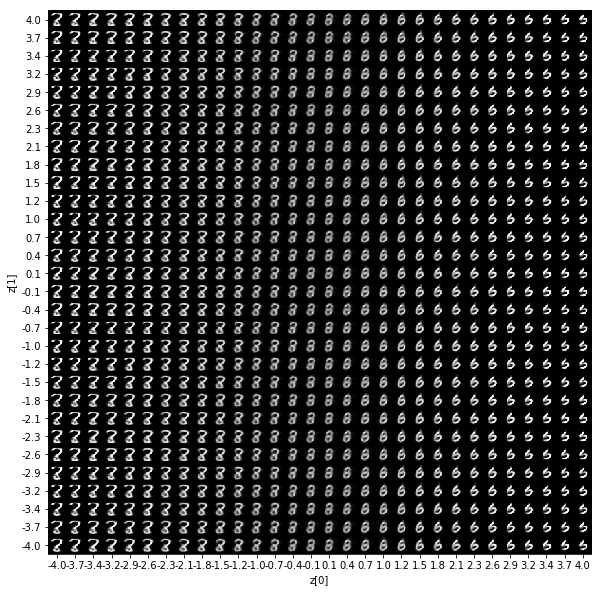

In [41]:
## DECODER - Latent Space Interpolation____________________________

def generate_interpolation_data(models, data, batch_size=128, model_name="vae_mlp"):
    
    print("latent dimensions:", modelArgs["latent_dim"])
    
    # display a 30x30 2D manifold of digits
    n = 30  # size of manifold
    digit_size = 28  # single figure size
    figure = np.zeros((digit_size * n, digit_size * n))

    
    ## Latent Space Dimension is 2 ______________________
    
    if modelArgs["latent_dim"] == 2:
            
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-4, 4, n)
        grid_y = np.linspace(-4, 4, n)[::-1] ## revert


        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.array([[xi, yi]])
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        start_range = digit_size // 2
        end_range = (n - 1) * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)


        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 
            
            
            
            
    ## Latent Space Dimension is larger than 2 ______________________
        
    if modelArgs["latent_dim"] > 2:
            
        # display a 30x30 2D manifold of digits
        n = 30  # size of manifold
        digit_size = 28  # single figure size
        figure = np.zeros((digit_size * n, digit_size * n))

        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-4, 4, n)
        grid_y = np.linspace(-4, 4, n)[::-1]
        
        z_sample = np.zeros(modelArgs["latent_dim"])
        z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
                
        ## visualize joint latent space of latent variable v1 and v2
        v0 = 0
        v1 = 1

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                
                z_sample[0][v0] = xi
                z_sample[0][v1] = xi
                x_decoded = decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit

        start_range = digit_size // 2
        end_range = (n - 1) * digit_size + start_range + 1
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)


        # Plot_____________________________

        plt.figure(figsize=(10, 10))
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[0]")
        plt.ylabel("z[1]")
        plt.imshow(figure, cmap='Greys_r')
        plt.show()

        if analyzeArgs["save_plots"] == True:
            filename = os.path.join(model_name, "digits_over_latent.png")
            plt.savefig(filename) 

            
## Generate Data _______________________________________

generate_interpolation_data(models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

## Visualize Latent Generative Distribution

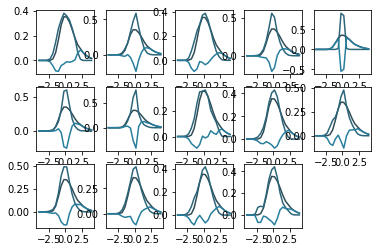

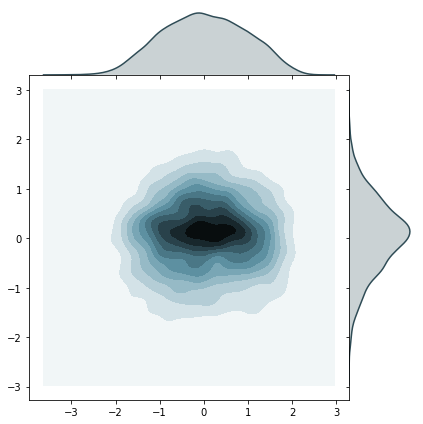

In [129]:
def visualize_latent_generative_dist(models,data,batch_size,model_name="vae_mnist"):

    encoder, decoder = models  # trained models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, z_log_var, z = encoder.predict(x_test, batch_size)


    # Plot Distributions _________________________________

    #plt.figure(figsize=(12, 10))
    #plt.scatter(z_mean[:, 0], z_mean[:, 1])
    #plt.xlabel("z[0]")
    #plt.ylabel("z[1]")
    #plt.show()

    #sns.set_palette("PuBuGn_d")
    #normal = np.random.normal(0.0, 1.0, 1000)  # mean, std, data_points

    #for i in range(1, modelArgs["latent_dim"]+1):

        #plt.subplot(3, 5, i)
        #sns.distplot(z_mean[:,i-1]).set_title("z_"+str(i))
        #sns.distplot(normal)
                
        
        
    ## Plot Difference Plot _______________________________
    
    normal = np.random.gumbel(0.0, 1.0, z_mean[:,0].shape[0])
    kde_normal = scipy.stats.gaussian_kde(normal)


    for i in range(1, modelArgs["latent_dim"]+1):

        plt.subplot(3, 5, i)
        plt.rcParams['figure.figsize']=(30,30)

        grid = np.linspace(-4,4, 20)
        kde_z = scipy.stats.gaussian_kde(z_mean[:,i-1])

        plt.plot(grid, kde_normal(grid), label="kde_normal")
        plt.plot(grid, kde_z(grid), label="kde_z")
        plt.plot(grid, kde_normal(grid)-kde_z(grid), label="difference")

        #plt.legend()

        
    ## Plot Joint Distribution Plot _______________________________

    ## outline how much learned variables deviates from normal distribution
    g = sns.jointplot(z_mean[:,0], z_mean[:,1], kind="kde", space=0)

    
visualize_latent_generative_dist(models,data,trainArgs["batch_size"],model_name="vae_mnist")

latent dimensions: 14


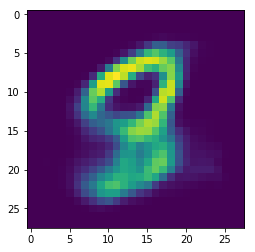

In [48]:
## apply decoder and generate data

def generate_single_instance(models, data, batch_size=128, model_name="vae_mlp"):
    
    print("latent dimensions:", modelArgs["latent_dim"])
    
    z_sample = np.zeros(modelArgs["latent_dim"])
    z_sample = np.reshape(z_sample, (1, modelArgs["latent_dim"]))
    
    
    ## visualize joint latent space of latent variable v1 and v2
    v0 = 0
    v1 = 1
    
    ## activations
    a0 = -1
    a1 = 3
                
    z_sample[0][v0] = a0
    z_sample[0][v1] = a1
    
    x_decoded = decoder.predict(z_sample)
    digit = x_decoded[0].reshape(28, 28)
    plt.imshow(digit)


        
generate_single_instance(models, data, batch_size=trainArgs["batch_size"], model_name="vae_mlp")

# To Do:

- add convolutions
- recurrent units 
...